# Class Challenge: Image Classification of COVID-19 X-rays
# Task 1 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Binary Classification: COVID-19 vs. Normal

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from tensorflow.keras import regularizers
import seaborn as sns
import time



os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.4.1'

#### Load Image Data

In [2]:
DATA_LIST = os.listdir('two/train')
DATASET_PATH  = 'two/train'
TEST_DIR =  'two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)

#hyper parameters (to change for better results)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.0005 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")

Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


c:\users\randr\appdata\local\programs\python\python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [4]:
model = Sequential()
layer1 = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape = (224,224,3), classes=2)
print(layer1.trainable)
layer1.trainable = False
model.add(layer1)
model.add(tf.keras.layers.BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu', name = 'dense256', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.add(tf.keras.layers.Activation('sigmoid'))
model.build(input_shape=(None, 224, 224, 3))
model.summary()

True
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 512)         2048      
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense256 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
_________________________________________________________________
activation (Activation)      (None, 1)             

#### [5 points] Train Model

In [5]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size


print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

11
3
10
2


In [6]:
opt = tf.optimizers.Adam(learning_rate=1e-3)
lossfn = 'binary_crossentropy'

model.compile(optimizer=opt,
                loss=lossfn,
                metrics=['accuracy'])

In [7]:
start = time.time()

history = model.fit(
    x = train_batches, 
    epochs=NUM_EPOCHS, 
    validation_data= valid_batches, 
    steps_per_epoch = STEP_SIZE_TRAIN,
    batch_size=BATCH_SIZE,
    validation_steps = STEP_SIZE_VALID
)


end = time.time()

c:\users\randr\appdata\local\programs\python\python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\randr\appdata\local\programs\python\python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/40
10/10 [==============================] - 18s 2s/step - loss: 6.8668 - accuracy: 0.5818 - val_loss: 4.8761 - val_accuracy: 0.7500
Epoch 2/40
10/10 [==============================] - 16s 2s/step - loss: 5.8184 - accuracy: 0.7217 - val_loss: 4.5829 - val_accuracy: 0.7500
Epoch 3/40
10/10 [==============================] - 16s 2s/step - loss: 3.9623 - accuracy: 0.8978 - val_loss: 4.6023 - val_accuracy: 0.5500
Epoch 4/40
10/10 [==============================] - 17s 2s/step - loss: 4.5318 - accuracy: 0.8267 - val_loss: 3.7710 - val_accuracy: 0.8000
Epoch 5/40
10/10 [==============================] - 17s 2s/step - loss: 3.4198 - accuracy: 0.8985 - val_loss: 3.5291 - val_accuracy: 0.7500
Epoch 6/40
10/10 [==============================] - 16s 2s/step - loss: 3.0048 - accuracy: 0.9018 - val_loss: 3.3416 - val_accuracy: 0.6000
Epoch 7/40
10/10 [==============================] - 15s 2s/step - loss: 2.9151 - accuracy: 0.8640 - val_loss: 2.5090 - val_accuracy: 0.9500
Epoch 8/40
10/10 [==

In [8]:
print("Model RunTime (seconds):",end - start)

Model RunTime (seconds): 643.9939467906952


#### [5 points] Plot Accuracy and Loss During Training

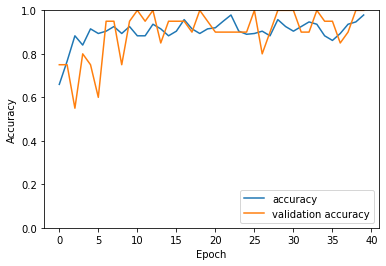

In [9]:
import matplotlib.pyplot as plt

#raise NotImplementedError("Plot the accuracy and the loss during training")

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

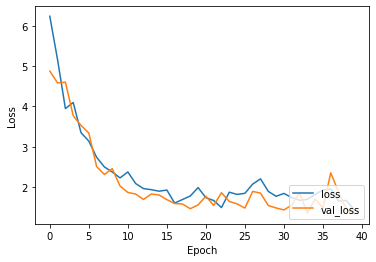

In [10]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

#### Plot Test Results

Found 18 images belonging to 2 classes.


c:\users\randr\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


18/18 [==============================] - 3s 135ms/step
covid\nejmoa2001191_f3-PA.jpeg


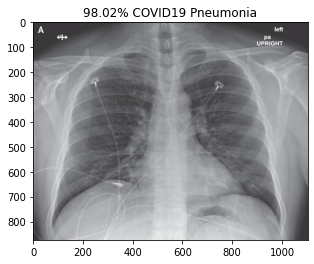

covid\nejmoa2001191_f4.jpeg


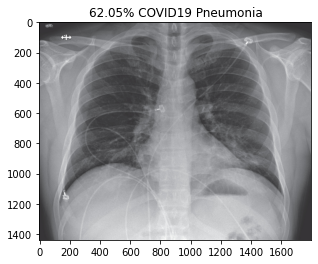

covid\nejmoa2001191_f5-PA.jpeg


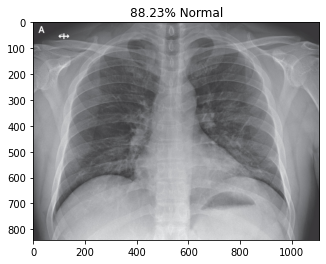

covid\radiol.2020200490.fig3.jpeg


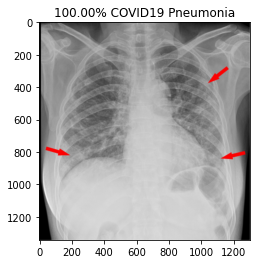

covid\ryct.2020200028.fig1a.jpeg


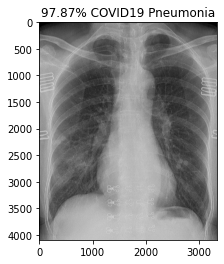

covid\ryct.2020200034.fig2.jpeg


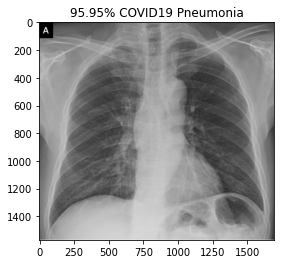

covid\ryct.2020200034.fig5-day0.jpeg


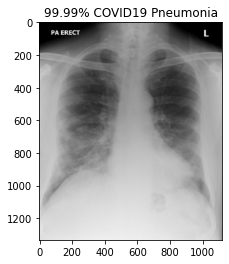

covid\ryct.2020200034.fig5-day4.jpeg


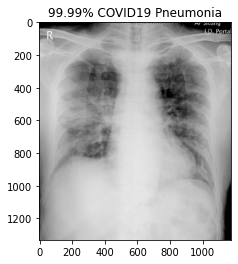

covid\ryct.2020200034.fig5-day7.jpeg


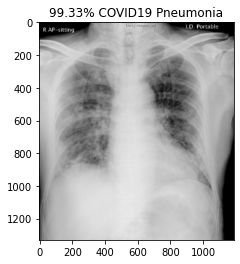

normal\NORMAL2-IM-1385-0001.jpeg


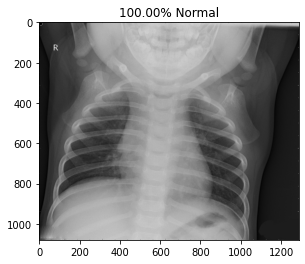

normal\NORMAL2-IM-1396-0001.jpeg


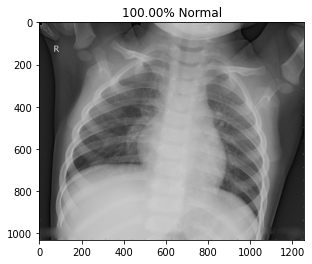

normal\NORMAL2-IM-1400-0001.jpeg


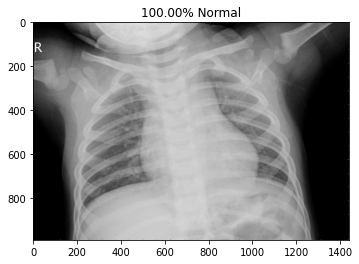

normal\NORMAL2-IM-1401-0001.jpeg


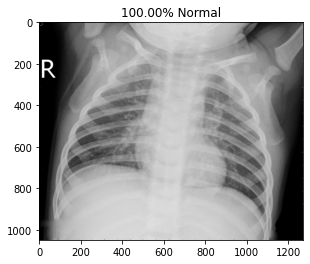

normal\NORMAL2-IM-1406-0001.jpeg


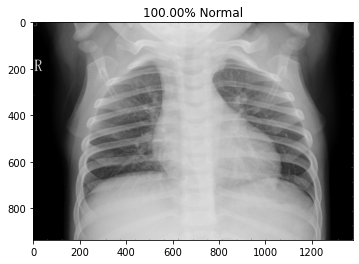

normal\NORMAL2-IM-1412-0001.jpeg


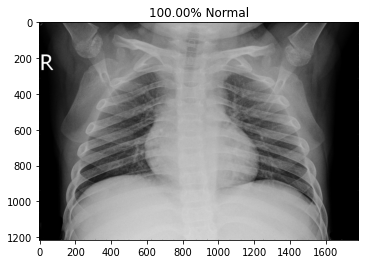

normal\NORMAL2-IM-1419-0001.jpeg


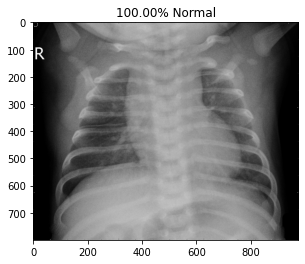

normal\NORMAL2-IM-1422-0001.jpeg


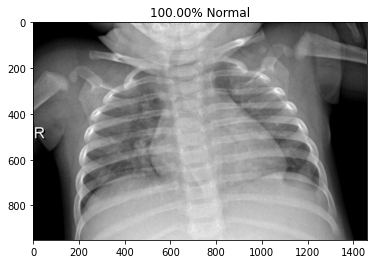

normal\NORMAL2-IM-1423-0001.jpeg


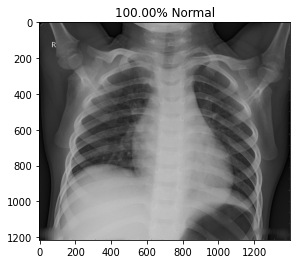

In [11]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")
eval_generator.reset()
pred = model.predict_generator(eval_generator,18,verbose=1)
for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

In [12]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 18 images belonging to 2 classes.
18


c:\users\randr\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


18/18 [==============================] - 2s 136ms/step - loss: 1.4612 - accuracy: 0.9444
Test loss: 1.461168885231018
Test accuracy: 0.9444444179534912


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 512)         2048      
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense256 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
_________________________________________________________________
activation (Activation)      (None, 1)                 0

In [14]:
from sklearn.manifold import TSNE
import tensorflow.keras.models as models


intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense').output)
tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary")


intermediate_layer_model.summary()

Found 130 images belonging to 2 classes.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 512)         2048      
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense256 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)       

In [15]:
outputs = intermediate_layer_model.predict(tsne_data_generator)
predictions = model.predict(tsne_data_generator)
one_zero_pred = np.rint(predictions)

In [16]:
tsne = TSNE(n_components=2, verbose=1)
tsne_proj = tsne.fit_transform(outputs)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 130 samples in 0.000s...
[t-SNE] Computed neighbors for 130 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 130 / 130
[t-SNE] Mean sigma: 2.945844
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.383549
[t-SNE] KL divergence after 800 iterations: 0.073865


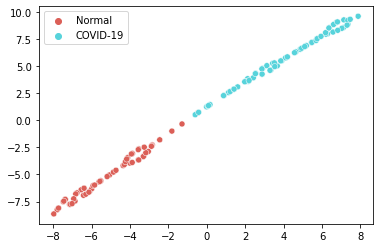

In [17]:
c = tsne_data_generator.labels

scat=sns.scatterplot(x=tsne_proj[:,0],y=tsne_proj[:,1], hue=c, palette=sns.color_palette("hls", 2))
handles, labels = scat.get_legend_handles_labels()
scat.legend(handles, ['Normal', 'COVID-19'])